<a href="https://colab.research.google.com/github/malgorzatagwinner/text_classification/blob/main/sbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Training overview</b>

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sentence_transformers import SentenceTransformer, models, util
import nltk
nltk.download('punkt')
import glob
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from tqdm.notebook import tqdm_notebook
import pickle

In [ ]:
l_sents= []
sents = set()
for filename in tqdm_notebook(glob.glob(f'/content/drive/My Drive/corpus/*.txt')):
    sents = set()
    with open(filename, 'r', encoding="utf8", errors='ignore') as in_file: 
        text = in_file.read().replace('\n', ' ')
    sents |= set(nltk.sent_tokenize(text))
    sents = list(sents)
    _, tail = os.path.split(filename)
    auth = tail.split("_")[0]
    l_sents.append((auth,sents,tail))

len(l_sents[0])

  0%|          | 0/100 [00:00<?, ?it/s]

3

In [ ]:
sum([len(x[1]) for x in l_sents])

785752

In [ ]:
len(l_sents[0])

3

In [ ]:
l_sents[0]

('Woolf',
 ['A sigh of air rushed up with it.',
  'Footsteps scurried about hither and thither on the floor above.',
  'Eleanor felt that she could relax.',
  'And the walloping Oxford bells, turning over and over like slow porpoises in a sea of oil, contemplatively intoned their musical incantation.',
  '"Hurrah!"',
  'It must fall.',
  'The family pressed a little closer to the graveside and looked fixedly at the coffin which lay with its polish and its brass handles there in the earth to be buried for ever.',
  'But how could she describe it?',
  'She spoke with some bitterness.',
  'She resigned the poker.',
  'said the young woman.',
  '"My father had these rooms, sir," the Colonel had said, by way of apology.',
  '"One never likes one\'s own picture," she said.',
  'She felt as if some dull bore had interrupted an interesting conversation.',
  '"They get into one\'s hair," Celia said.',
  '"Come and talk to us!"',
  '"Dancing .',
  'That turn was over - the old- brother-and-siste

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
import numpy as np

In [ ]:
from os.path import exists

PATH = '/content/drive/My Drive/encodings/'
embeddings_l = []
authors_d = {}
authors_l = []
for i in tqdm_notebook(l_sents):
    filename = PATH + i[2] + '.pickle'
    if exists(filename): # load
        with open(filename, 'rb') as f:
            embeddings = pickle.load(f)
    else: # calculate and save
        embeddings = model.encode(i[1])
        with open(filename, 'wb') as f:
            pickle.dump(embeddings, f, pickle.HIGHEST_PROTOCOL)
    embeddings_l.append(embeddings)
    if not i[0] in authors_d:
        authors_d[i[0]] = len(authors_d)
    authors_l.append(authors_d[i[0]])

authors_l = np.array(authors_l)
model = 0

embeddings.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(10394, 384)

In [ ]:
len(embeddings_l[0][0])

384

Cutting the data into smaller, 200-sized parts

In [ ]:
batches = []
authors_b = []
batch_len = 2
for i in range (0, len(embeddings_l), ):
    #s = []
    for j in range(0, len(embeddings_l[i])-batch_len, batch_len):
        batches.append(embeddings_l[i][j:j+batch_len])
        authors_b.append(authors_l[i])

batches = np.asarray(batches)
authors_b = np.asarray(authors_b)
len(authors_b)

392802

In [ ]:
batches_sum = []
for batch in batches:
    batch_sum = np.zeros(384)
    for i in batch:
        batch_sum += i
    batches_sum.append(batch_sum)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(batches_sum, authors_b, test_size=0.2, random_state=42)

In [ ]:
clf = svm.SVC()
clf.fit(x_train, y_train)

In [ ]:
svm_pred = clf.predict(x_test)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
accuracy_score(y_test, svm_pred)

In [ ]:
#list(zip(y_test, svm_pred))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
cmp = ConfusionMatrixDisplay.from_predictions(y_test, svm_pred)
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticklabels(authors_d.keys(), rotation='vertical') 
cmp.plot(ax=ax)

**Neural Network**


In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
import random

In [ ]:
#NUMBER = min(map(len, embeddings_l))
#sample = map(lambda x: random.sample(list(x), NUMBER), embeddings_l)
#x = tf.data.Dataset.from_tensor_slices(list(sample))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(batches, authors_b, test_size=0.20)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
#X_train = x.take(80)
#X_test = x.skip(80)

#y_train = tf.data.Dataset.from_tensor_slices(list(map(lambda x: tf.convert_to_tensor(x),authors_l[:80])))
#y_test = tf.data.Dataset.from_tensor_slices(list(map(lambda x: tf.convert_to_tensor(x),authors_l[80:100])))

In [ ]:
from keras.models import Sequential
from keras import Input, Model
from keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, Reshape

'''
nn_model = Sequential()
#nn_model.add(Input(shape=(None,384,1)))
nn_model.add(Input(shape=(None,384)))
nn_model.add(Conv1D(filters=48, kernel_size=3, strides=1, activation="relu"))
nn_model.add(MaxPooling1D(pool_size=2, strides=4))
nn_model.add(Dense(len(authors_d)))
nn_model.compile(loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()
'''

_inputs = Input(shape=(200, 384, 1), batch_size=None)#embeddings_l.shape[0])
_outputs = _inputs
#_outputs = Reshape((384,1))(_outputs)
_outputs = Conv2D(filters=20, kernel_size=3, activation="relu")(_outputs)
_outputs = MaxPooling2D(pool_size=(1,64), strides=4)(_outputs)
_outputs = Dense(len(authors_d))(_outputs)
_outputs = Dense(1)(_outputs)
nn_model = Model(inputs=_inputs, outputs=_outputs)
nn_model.compile(loss='binary_crossentropy',metrics=['accuracy'])
nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 384, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 198, 382, 20)      200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 80, 20)       0         
 )                                                               
                                                                 
 dense (Dense)               (None, 50, 80, 34)        714       
                                                                 
 dense_1 (Dense)             (None, 50, 80, 1)         35        
                                                                 
Total params: 949
Trainable params: 949
Non-trainable params: 0
_______________________________________________________________

In [ ]:
[print(i.shape, i.dtype) for i in nn_model.inputs]
[print(o.shape, o.dtype) for o in nn_model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in nn_model.layers]

(None, 200, 384, 1) <dtype: 'float32'>
(None, 50, 80, 1) <dtype: 'float32'>
input_1 [(None, 200, 384, 1)] float32
conv2d (None, 200, 384, 1) float32
max_pooling2d (None, 198, 382, 20) float32
dense (None, 50, 80, 20) float32
dense_1 (None, 50, 80, 34) float32


[None, None, None, None, None]

In [ ]:
#history = nn_model.fit(X_train, y_train,
#                    epochs=50,
#                    verbose=False, validation_data=(X_test, y_test) )
#loss, accuracy = nn_model.evaluate(X_train, y_train, verbose=False)
#print("Training Accuracy: {:.4f}".format(accuracy))
#loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=False)
#print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
#history.history

In [ ]:
"""
if exists('/content/drive/My Drive/model.txt'): # load
        with open('/content/drive/My Drive/model.txt', 'rb') as f:
            nn_model = pickle.load(f)
else:
    with open('/content/drive/My Drive/model.txt', 'wb') as f:
        pickle.dump(nn_model, f, pickle.HIGHEST_PROTOCOL)


if exists('/content/drive/My Drive/history.txt'): # load
        with open('/content/drive/My Drive/history.txt', 'rb') as f:
            history = pickle.load(f)
else:
    with open('/content/drive/My Drive/history.txt', 'wb') as f:
        pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)
        """

"\nif exists('/content/drive/My Drive/model.txt'): # load\n        with open('/content/drive/My Drive/model.txt', 'rb') as f:\n            nn_model = pickle.load(f)\nelse:\n    with open('/content/drive/My Drive/model.txt', 'wb') as f:\n        pickle.dump(nn_model, f, pickle.HIGHEST_PROTOCOL)\n\n\nif exists('/content/drive/My Drive/history.txt'): # load\n        with open('/content/drive/My Drive/history.txt', 'rb') as f:\n            history = pickle.load(f)\nelse:\n    with open('/content/drive/My Drive/history.txt', 'wb') as f:\n        pickle.dump(history, f, pickle.HIGHEST_PROTOCOL)\n        "

In [ ]:
"""import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
"""

"import matplotlib.pyplot as plt\nplt.style.use('ggplot')\n\ndef plot_history(history):\n    acc = history.history['accuracy']\n    val_acc = history.history['val_accuracy']\n    loss = history.history['loss']\n    val_loss = history.history['val_loss']\n    x = range(1, len(acc) + 1)\n\n    plt.figure(figsize=(12, 5))\n    plt.subplot(1, 2, 1)\n    plt.plot(x, acc, 'b', label='Training acc')\n    plt.plot(x, val_acc, 'r', label='Validation acc')\n    plt.title('Training and validation accuracy')\n    plt.legend()\n    plt.subplot(1, 2, 2)\n    plt.plot(x, loss, 'b', label='Training loss')\n    plt.plot(x, val_loss, 'r', label='Validation loss')\n    plt.title('Training and validation loss')\n    plt.legend()\n"

In [ ]:
#plot_history(history)

In [ ]:
# import tensorflow as tf
# # Define Sequential model with 3 layers
# mmodel = keras.Sequential(
#     [   Input(shape=(None, 3)),
#         Dense(2, activation="relu", name="layer1"),
#         #Dense(3, activation="relu", name="layer2"),
#         #Dense(4, name="layer3"),
#     ]
# )
# # Call model on a test input
# x = tf.ones((3, 3))
# y = mmodel(x)
# y

**TSAI**

In [ ]:
pip install tsai[extras]6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 7.4 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 2.5 MB 48.9 MB/s 
     |████████████████████████████████| 97 kB 9.2 MB/s 
     |████████████████████████████████| 6.9 MB 14.2 MB/s 
     |████████████████████████████████| 9.8 MB 1.5 MB/s 
     |████████████████████████████████| 19.1 MB 438 kB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 21.0 MB 742 kB/s 
     |████████████████████████████████| 837 kB 61.1 MB/s 
     |████████████████████████████████| 1.1 MB 61.4 MB/s 
     |████████████████████████████████| 136 kB 79.8 MB/s 
     |████████████████████████████████| 141 kB 74.2 MB/s 
     |████████████████████████████████| 830 kB 67.7 MB/s 
     |████████████████████████████████| 822 kB 54.2 MB/s 
     |█████████████████████████████

In [ ]:
from tsai.all import *
import sktime
computer_setup()

/usr/local/lib/python3.7/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.7/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


os             : Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
python         : 3.7.13
tsai           : 0.3.1
fastai         : 2.7.9
fastcore       : 1.5.17
torch          : 1.12.1+cu113
device         : cpu
cpu cores      : 2
RAM            : 12.68 GB
GPU memory     : N/A


do tsai, nie przejmując się podziałem na dokumenty

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
a = pca.fit_transform(np.reshape(batches, (-1, 384)))
pca_comp = np.asarray(pca.components_)

In [ ]:
len(authors_b)

3883

In [ ]:
np.reshape(batches, (-1, 384)).shape

(776600, 384)

In [ ]:
# X, y, splits = get_classification_data('ECG200', split_data=False)
# batch_tfms = TSStandardize()

# splits = TimeSplitter(235)(authors_b) 
# clf = TSClassifier(a, authors_b, splits=splits, path='models', arch=XceptionTime, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
# clf.fit_one_cycle(100, 3e-4)
# clf.export("clf.pkl")

TSAI Z XceptionTime bez dodawania żadnych informacji

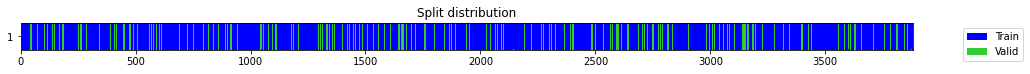

epoch,train_loss,valid_loss,accuracy,time
0,3.477488,3.469415,0.057990,01:23
1,3.427984,3.381950,0.221649,01:12
2,3.356895,3.282600,0.389175,01:22
3,3.261019,3.154124,0.569588,01:14
4,3.139519,3.006337,0.711340,01:11
5,2.994392,2.839140,0.811856,01:14
6,2.833282,2.656198,0.895619,01:11
7,2.659531,2.428585,0.923969,01:14
8,2.445920,2.139872,0.944588,01:11
9,2.180238,1.789334,0.954897,01:14


KeyboardInterrupt: ignored

In [ ]:
splits = get_splits(authors_b, valid_size=.2, stratify=True, random_state=23, shuffle=True)
clf = TSClassifier(np.transpose(batches, (0, 2, 1)), authors_b, splits=splits, path='models', arch=XceptionTime, metrics=accuracy)
clf.fit_one_cycle(100, 3e-4)
clf.export("clf_RTX.pkl")

In [ ]:
l_docs = []
for i in l_sents:
    l_docs.append(sum(i))

MiniRocket

In [ ]:
from tsai.models.MINIROCKET import *
splits = TimeSplitter(235)(authors_b) 
rclf = MiniRocketClassifier(verbose=True)
rclf.fit(batches, authors_b)# splits=splits, path='models')

TSAI z XceptionTime bez dodawania żadnych informacji

In [ ]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

NameError: ignored

In [ ]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

NameError: ignored